# 🚗 Büyük Veri ve Analitiği - Dönem Projesi
## Uçtan Uca Data Pipeline: US Accidents Dataset
### 📊 TÜM 7.7 MİLYON VERİ İŞLENECEK

---

**🖥️ Çalışma Modu: Google Colab + Lokal Runtime**
- Colab arayüzünden yönetim
- Lokal PC'nin 32GB RAM'i kullanılacak
- Tüm 7,728,394 kayıt işlenecek

**Proje Bileşenleri:**
1. Veri Alma (Lokal CSV)
2. Veri Temizleme (PySpark)
3. kNN Sınıflandırma + Performans Metrikleri (TÜM VERİ)
4. K-Means Kümeleme + Görselleştirme (TÜM VERİ)
5. Çıktıların JSON olarak dışa aktarılması (TÜM VERİ)
6. MongoDB'ye veri yükleme

**Teknolojiler:** Google Colab (Local Runtime), PySpark, MongoDB, Python

---

## 📦 Bölüm 1: Kurulum ve Kütüphaneler

In [1]:
# ============================================================================
# LOKAL RUNTIME İÇİN KURULUM
# ============================================================================
# Bu notebook Colab'dan lokal bilgisayara bağlanarak çalışacak
# Lokal PC'de gerekli kütüphaneler zaten kurulu olmalı

# Eğer kurulu değilse, lokal terminalde şu komutları çalıştırın:
# pip install pyspark==3.5.0 pandas matplotlib seaborn scikit-learn

import subprocess
import sys
import importlib.util

# Kütüphaneleri kontrol et ve gerekirse kur
# Not: PySpark için Windows uyumluluk sorunu nedeniyle versiyon 3.5.0 kullanılmalı
required_packages = {
    'pyspark': 'pyspark==3.5.0',  # Windows uyumluluğu için 3.5.0
    'pandas': 'pandas',
    'matplotlib': 'matplotlib', 
    'seaborn': 'seaborn',
    'scikit-learn': 'sklearn'  # import adı farklı
}

for package, install_name in required_packages.items():
    # Import adını belirle (scikit-learn -> sklearn)
    import_name = 'sklearn' if package == 'scikit-learn' else package.replace('-', '_')
    
    # Paketi importlib ile kontrol et (import etmeden)
    spec = importlib.util.find_spec(import_name)
    
    if spec is not None:
        print(f"✅ {package} kurulu")
    else:
        print(f"📦 {package} kuruluyor...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", install_name, "-q"])
        print(f"✅ {package} kuruldu")

print("\n✅ Tüm gerekli kütüphaneler hazır!")
print("⚠️  Not: Windows'ta PySpark 3.5.0 kullanılması önerilir.")

✅ pyspark kurulu
✅ pandas kurulu
✅ matplotlib kurulu
✅ seaborn kurulu
✅ scikit-learn kurulu

✅ Tüm gerekli kütüphaneler hazır!
⚠️  Not: Windows'ta PySpark 3.5.0 kullanılması önerilir.


In [2]:
from pyspark.sql.types import IntegerType, DoubleType, StringType, NumericType

In [3]:
# ============================================================================
# KÜTÜPHANELERİ IMPORT ETME - LOKAL RUNTIME
# ============================================================================
import os
import json
import glob
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan, isnull, mean, stddev, hour, dayofweek, month, year, rand
from pyspark.sql.types import IntegerType, DoubleType, StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

# Scikit-learn
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier as SklearnKNN
from sklearn.preprocessing import StandardScaler as SklearnScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score
from sklearn.preprocessing import label_binarize

# Sistem bilgisi
import psutil
total_ram = psutil.virtual_memory().total / (1024**3)
available_ram = psutil.virtual_memory().available / (1024**3)

print("="*60)
print("🖥️  LOKAL RUNTIME - SİSTEM BİLGİSİ")
print("="*60)
print(f"📊 Toplam RAM: {total_ram:.1f} GB")
print(f"📊 Kullanılabilir RAM: {available_ram:.1f} GB")
print(f"📊 CPU Çekirdek: {psutil.cpu_count()}")
print("="*60)
print("✅ Tüm kütüphaneler başarıyla import edildi!")
print("📍 Colab Local Runtime modu aktif - 32GB RAM kullanılacak")

🖥️  LOKAL RUNTIME - SİSTEM BİLGİSİ
📊 Toplam RAM: 31.1 GB
📊 Kullanılabilir RAM: 20.3 GB
📊 CPU Çekirdek: 16
✅ Tüm kütüphaneler başarıyla import edildi!
📍 Colab Local Runtime modu aktif - 32GB RAM kullanılacak


## 🔽 Bölüm 2: Veri Alma (Data Ingestion)

Lokal bilgisayardaki CSV dosyasını yükleyeceğiz. (7.7M kayıt)

In [4]:
# ============================================================================
# LOKAL VERİ DOSYASI KONTROLÜ
# ============================================================================
# Colab Local Runtime ile lokal bilgisayardaki dosyaya erişiyoruz

# Veri dosyası yolu - KENDİ YOLUNUZA GÖRE DEĞİŞTİRİN
DATA_PATH = r"C:\Users\fatih\OneDrive\Masaüstü\BuyukVeri\Pipeline_Collab\US_Accidents_March23.csv"

# Çıktı klasörü
OUTPUT_DIR = r"C:\Users\fatih\OneDrive\Masaüstü\BuyukVeri\Pipeline_Collab\outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("📁 Veri Dosyası Kontrolü")
print("="*60)

if os.path.exists(DATA_PATH):
    file_size = os.path.getsize(DATA_PATH) / (1024**3)  # GB
    print(f"✅ Veri dosyası bulundu!")
    print(f"📁 Yol: {DATA_PATH}")
    print(f"📊 Boyut: {file_size:.2f} GB")
else:
    print(f"❌ Veri dosyası bulunamadı: {DATA_PATH}")
    print("\n⚠️ Lütfen CSV dosyasını bu konuma kopyalayın veya yolu düzenleyin.")
    raise FileNotFoundError(f"Dosya bulunamadı: {DATA_PATH}")

📁 Veri Dosyası Kontrolü
✅ Veri dosyası bulundu!
📁 Yol: C:\Users\fatih\OneDrive\Masaüstü\BuyukVeri\Pipeline_Collab\US_Accidents_March23.csv
📊 Boyut: 2.85 GB


In [5]:
# ============================================================================
# BU HÜCRE LOKAL RUNTIME İÇİN GEREKLİ DEĞİL - ATLANDI
# ============================================================================
# Kaggle API lokal runtime'da kullanılmıyor
# Veri dosyası zaten lokal diskte mevcut

print("📍 Lokal Runtime - Kaggle API gerekmez")
print("✅ Veri dosyası lokal diskten yüklenecek")

📍 Lokal Runtime - Kaggle API gerekmez
✅ Veri dosyası lokal diskten yüklenecek


In [6]:
# ============================================================================
# BU HÜCRE LOKAL RUNTIME İÇİN GEREKLİ DEĞİL - ATLANDI
# ============================================================================
# Kaggle'dan indirme lokal runtime'da yapılmıyor
# Veri dosyası zaten lokal diskte mevcut

print("📍 Lokal Runtime - Kaggle indirme gerekmez")
print(f"✅ Veri dosyası mevcut: {DATA_PATH}")

📍 Lokal Runtime - Kaggle indirme gerekmez
✅ Veri dosyası mevcut: C:\Users\fatih\OneDrive\Masaüstü\BuyukVeri\Pipeline_Collab\US_Accidents_March23.csv


In [7]:
# ============================================================================
# VERİ DOSYASI BİLGİSİ
# ============================================================================

print("📁 Veri Dosyası Bilgisi:")
print("="*60)

size_gb = os.path.getsize(DATA_PATH) / (1024**3)
size_mb = os.path.getsize(DATA_PATH) / (1024**2)

print(f"📄 Dosya: {os.path.basename(DATA_PATH)}")
print(f"📊 Boyut: {size_gb:.2f} GB ({size_mb:.0f} MB)")
print(f"📁 Konum: {os.path.dirname(DATA_PATH)}")

📁 Veri Dosyası Bilgisi:
📄 Dosya: US_Accidents_March23.csv
📊 Boyut: 2.85 GB (2917 MB)
📁 Konum: C:\Users\fatih\OneDrive\Masaüstü\BuyukVeri\Pipeline_Collab


## 🔥 Bölüm 3: PySpark Oturumu Başlatma

In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SparkTest") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

print("Spark Version:", spark.version)
spark.range(5).show()


Spark Version: 3.5.0
+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+



In [9]:
# ============================================================================
# VERİYİ PYSPARK DATAFRAME OLARAK YÜKLE - TÜM 7.7M VERİ
# ============================================================================

print("📊 TÜM VERİ yükleniyor (7.7 milyon kayıt)...")
print("="*60)
print(f"📁 Dosya: {DATA_PATH}")
print("⏳ Bu işlem birkaç dakika sürebilir...")

# CSV dosyasını yükle
df_spark = spark.read.csv(DATA_PATH, header=True, inferSchema=True)

# Veriyi cache'le (tekrar tekrar okumamak için)
df_spark.cache()

# Kayıt sayısını al
total_count = df_spark.count()

print(f"\n✅ VERİ BAŞARIYLA YÜKLENDİ!")
print("="*60)
print(f"📊 Toplam kayıt sayısı: {total_count:,}")
print(f"📊 Toplam sütun sayısı: {len(df_spark.columns)}")
print(f"📊 Bellek kullanımı: ~{(total_count * 46 * 50) / (1024**3):.1f} GB (tahmini)")

📊 TÜM VERİ yükleniyor (7.7 milyon kayıt)...
📁 Dosya: C:\Users\fatih\OneDrive\Masaüstü\BuyukVeri\Pipeline_Collab\US_Accidents_March23.csv
⏳ Bu işlem birkaç dakika sürebilir...

✅ VERİ BAŞARIYLA YÜKLENDİ!
📊 Toplam kayıt sayısı: 7,728,394
📊 Toplam sütun sayısı: 46
📊 Bellek kullanımı: ~16.6 GB (tahmini)


In [10]:
# Veri şemasını görüntüle
print("📋 Veri Şeması:")
print("="*60)
df_spark.printSchema()

📋 Veri Şeması:
root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable

In [11]:
# İlk 5 kaydı görüntüle
print("📋 İlk 5 Kayıt:")
df_spark.show(5, truncate=False)

📋 İlk 5 Kayıt:
+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+-------------------------------------------------------------------------------------+-------------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|ID |Source |Severity|Start_Time         |End_Time           |Start_Lat        |Start_Lng         |End_Lat|End_Lng|Distance(mi)|Description                                                                          |Street                   |City        |County    |State|Zipcode   |Country|Timezone  |Airport_Code|Weathe

In [12]:
# Temel istatistikler
print("📊 Temel İstatistikler:")
df_spark.describe().show()

📊 Temel İstatistikler:
+-------+--------+-------+------------------+-----------------+------------------+-----------------+------------------+------------------+--------------------+------------------+----------+---------+-------+------------------+-------+----------+------------+------------------+-----------------+------------------+------------------+-----------------+--------------+-----------------+--------------------+------------------+--------------+--------------+-----------------+---------------------+
|summary|      ID| Source|          Severity|        Start_Lat|         Start_Lng|          End_Lat|           End_Lng|      Distance(mi)|         Description|            Street|      City|   County|  State|           Zipcode|Country|  Timezone|Airport_Code|    Temperature(F)|    Wind_Chill(F)|       Humidity(%)|      Pressure(in)|   Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|   Precipitation(in)| Weather_Condition|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomic

## 🧹 Bölüm 4: Veri Temizleme ve Ön İşleme (PySpark)

In [13]:
# Eksik değer analizi (OPTİMİZE EDİLMİŞ - tek seferde hesaplama)
print("📊 Eksik Değer Analizi:")
print("="*60)

# Toplam satır sayısı
total_rows = df_spark.count()
print(f"📊 Toplam satır: {total_rows:,}")

# TÜM sütunların null değerlerini TEK SEFERDE hesapla (çok daha hızlı!)
from pyspark.sql.functions import sum as spark_sum, when, col, isnan

# Her sütun için null sayısını hesapla
null_counts_expr = []
for column in df_spark.columns:
    # isNull kontrolü (tüm tipler için)
    null_counts_expr.append(
        spark_sum(when(col(column).isNull(), 1).otherwise(0)).alias(column)
    )

# Tek seferde tüm null'ları say
null_counts_row = df_spark.select(null_counts_expr).collect()[0]

# Sonuçları DataFrame'e çevir
null_counts = []
for column in df_spark.columns:
    null_count = null_counts_row[column]
    if null_count > 0:
        null_percent = (null_count / total_rows) * 100
        null_counts.append((column, null_count, null_percent))

# Eksik değerleri göster
null_df = pd.DataFrame(null_counts, columns=['Sütun', 'Eksik Sayısı', 'Eksik %'])
null_df = null_df.sort_values('Eksik %', ascending=False)
print(f"\n📋 Eksik değer içeren {len(null_df)} sütun bulundu:")
print(null_df.head(20).to_string(index=False))

📊 Eksik Değer Analizi:
📊 Toplam satır: 7,728,394

📋 Eksik değer içeren 22 sütun bulundu:
                Sütun  Eksik Sayısı   Eksik %
              End_Lat       3402762 44.029355
              End_Lng       3402762 44.029355
    Precipitation(in)       2203586 28.512858
        Wind_Chill(F)       1999019 25.865904
      Wind_Speed(mph)        571233  7.391355
       Visibility(mi)        177098  2.291524
       Wind_Direction        175206  2.267043
          Humidity(%)        174144  2.253301
    Weather_Condition        173459  2.244438
       Temperature(F)        163853  2.120143
         Pressure(in)        140679  1.820288
    Weather_Timestamp        120228  1.555666
       Sunrise_Sunset         23246  0.300787
       Civil_Twilight         23246  0.300787
    Nautical_Twilight         23246  0.300787
Astronomical_Twilight         23246  0.300787
         Airport_Code         22635  0.292881
               Street         10869  0.140637
             Timezone          7808  

In [14]:
# Analiz için önemli sütunları seç
# Sınıflandırma hedefi: Severity (1-4)
# Kümeleme özellikleri: Coğrafi ve çevresel faktörler

selected_columns = [
    'Severity',           # Hedef değişken (1-4)
    'Start_Lat',          # Enlem
    'Start_Lng',          # Boylam
    'Distance(mi)',       # Etkilenen mesafe
    'Temperature(F)',     # Sıcaklık
    'Humidity(%)',        # Nem
    'Pressure(in)',       # Basınç
    'Visibility(mi)',     # Görüş mesafesi
    'Wind_Speed(mph)',    # Rüzgar hızı
    'Precipitation(in)',  # Yağış
    'Weather_Condition',  # Hava durumu
    'Sunrise_Sunset',     # Gündüz/Gece
    'Civil_Twilight',     # Alacakaranlık
    'State'               # Eyalet
]

# Seçili sütunlarla yeni DataFrame oluştur
df_selected = df_spark.select(selected_columns)
print(f"✅ {len(selected_columns)} sütun seçildi.")
df_selected.show(5)

✅ 14 sütun seçildi.
+--------+-----------------+------------------+------------+--------------+-----------+------------+--------------+---------------+-----------------+-----------------+--------------+--------------+-----+
|Severity|        Start_Lat|         Start_Lng|Distance(mi)|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Sunrise_Sunset|Civil_Twilight|State|
+--------+-----------------+------------------+------------+--------------+-----------+------------+--------------+---------------+-----------------+-----------------+--------------+--------------+-----+
|       3|        39.865147|        -84.058723|        0.01|          36.9|       91.0|       29.68|          10.0|           NULL|             0.02|       Light Rain|         Night|         Night|   OH|
|       2|39.92805900000001|        -82.831184|        0.01|          37.9|      100.0|       29.65|          10.0|           NULL|              0.0|       Light Ra

In [15]:
# Veri temizleme işlemleri
print("🧹 Veri Temizleme Başlıyor...")
print("="*60)

# 1. Eksik değerleri temizle (sadece sayısal sütunlar için ortalama ile doldur)
numeric_columns = ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)',
                   'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
                   'Wind_Speed(mph)', 'Precipitation(in)']

# Ortalama değerleri hesapla ve doldur
df_cleaned = df_selected

for col_name in numeric_columns:
    mean_val = df_cleaned.select(mean(col(col_name))).collect()[0][0]
    if mean_val is not None:
        df_cleaned = df_cleaned.fillna({col_name: mean_val})

# 2. Kategorik değişkenlerdeki eksik değerleri 'Unknown' ile doldur
categorical_columns = ['Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'State']
for col_name in categorical_columns:
    df_cleaned = df_cleaned.fillna({col_name: 'Unknown'})

# 3. Severity değeri null olan satırları kaldır (hedef değişken)
df_cleaned = df_cleaned.filter(col('Severity').isNotNull())

print(f"✅ Temizleme sonrası kayıt sayısı: {df_cleaned.count():,}")

🧹 Veri Temizleme Başlıyor...
✅ Temizleme sonrası kayıt sayısı: 7,728,394


In [16]:
# Kategorik değişkenleri sayısallaştır
print("🔄 Kategorik değişkenler sayısallaştırılıyor...")

# StringIndexer ile kategorik değişkenleri encode et
indexers = []
for col_name in categorical_columns:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_Index", handleInvalid="keep")
    indexers.append(indexer)

# Pipeline oluştur ve uygula
indexer_pipeline = Pipeline(stages=indexers)
df_indexed = indexer_pipeline.fit(df_cleaned).transform(df_cleaned)

print("✅ Kategorik değişkenler encode edildi!")
df_indexed.select([f"{c}_Index" for c in categorical_columns]).show(5)

🔄 Kategorik değişkenler sayısallaştırılıyor...
✅ Kategorik değişkenler encode edildi!
+-----------------------+--------------------+--------------------+-----------+
|Weather_Condition_Index|Sunrise_Sunset_Index|Civil_Twilight_Index|State_Index|
+-----------------------+--------------------+--------------------+-----------+
|                    6.0|                 1.0|                 1.0|       18.0|
|                    6.0|                 1.0|                 1.0|       18.0|
|                    5.0|                 1.0|                 1.0|       18.0|
|                    1.0|                 1.0|                 0.0|       18.0|
|                    1.0|                 0.0|                 0.0|       18.0|
+-----------------------+--------------------+--------------------+-----------+
only showing top 5 rows



In [17]:
# ============================================================================
# TÜM VERİYİ KULLAN - ÖRNEKLEME YOK
# ============================================================================
# PySpark dağıtık işlem yapacağı için tüm veriyi kullanabiliriz
# Sadece Pandas'a çevirirken parçalı işleme yapacağız

print("📊 TÜM VERİ kullanılacak - örnekleme yapılmıyor!")
print("="*60)

# Tüm veriyi df_sample olarak ata (isim uyumluluğu için)
df_sample = df_indexed

# Veriyi cache'le (tekrar tekrar okumamak için)
df_sample.cache()

total_count = df_sample.count()
print(f"✅ Toplam veri boyutu: {total_count:,} kayıt")
print(f"📊 Bu veri K-Means ve JSON export için kullanılacak")
print(f"📊 kNN için stratified sampling yapılacak (2M kayıt)")

📊 TÜM VERİ kullanılacak - örnekleme yapılmıyor!
✅ Toplam veri boyutu: 7,728,394 kayıt
📊 Bu veri K-Means ve JSON export için kullanılacak
📊 kNN için stratified sampling yapılacak (2M kayıt)


📊 Severity Dağılımı:
+--------+-------+
|Severity|  count|
+--------+-------+
|       1|  67366|
|       2|6156981|
|       3|1299337|
|       4| 204710|
+--------+-------+



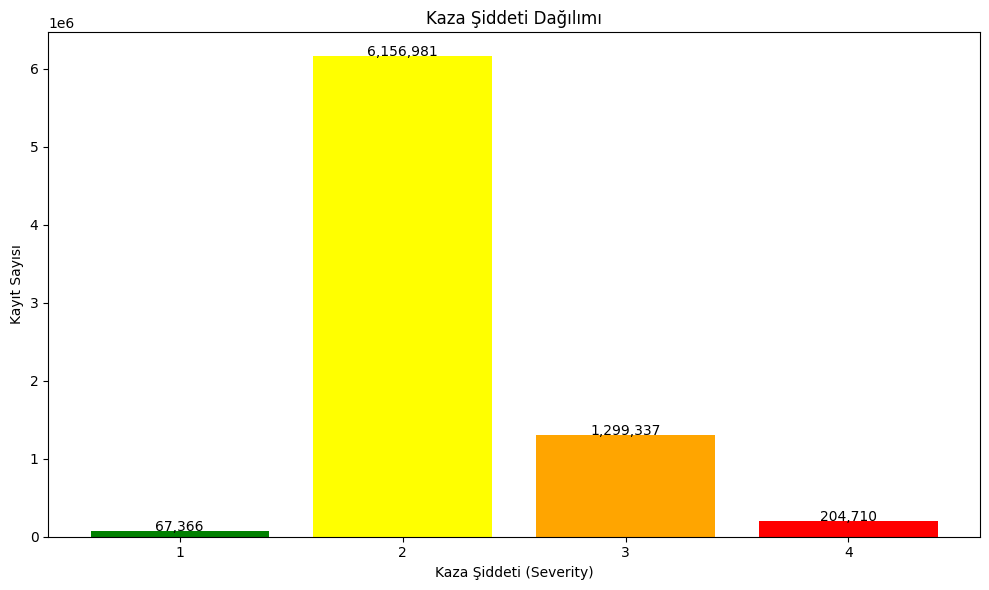

In [18]:
# Hedef değişken dağılımı (Severity)
print("📊 Severity Dağılımı:")
severity_dist = df_sample.groupBy('Severity').count().orderBy('Severity')
severity_dist.show()

# Görselleştirme için Pandas'a çevir
severity_pd = severity_dist.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(severity_pd['Severity'].astype(str), severity_pd['count'], color=['green', 'yellow', 'orange', 'red'])
plt.xlabel('Kaza Şiddeti (Severity)')
plt.ylabel('Kayıt Sayısı')
plt.title('Kaza Şiddeti Dağılımı')
for i, v in enumerate(severity_pd['count']):
    plt.text(i, v + 1000, f'{v:,}', ha='center', fontsize=10)
plt.tight_layout()
plt.savefig('severity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 🎯 Bölüm 5: kNN Sınıflandırma + Performans Metrikleri

Kaza şiddetini (Severity 1-4) tahmin etmek için kNN algoritması kullanacağız.

In [19]:
# Özellik vektörü oluştur
feature_columns = [
    'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)',
    'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
    'Precipitation(in)', 'Weather_Condition_Index', 'Sunrise_Sunset_Index',
    'Civil_Twilight_Index', 'State_Index'
]

# Eksik değerleri tekrar kontrol et ve temizle
for col_name in feature_columns:
    df_sample = df_sample.filter(col(col_name).isNotNull())

print(f"✅ Temiz veri sayısı: {df_sample.count():,}")

✅ Temiz veri sayısı: 7,728,394


In [20]:
# ============================================================================
# 🚀 TÜM 7.7M VERİYİ PANDAS'A ÇEVIR - LOKAL RUNTIME (32GB RAM)
# ============================================================================
# Lokal runtime'da 32GB RAM olduğu için TÜM VERİYİ kullanabiliriz!
# Örnekleme yapmaya gerek yok

print("📊 TÜM VERİ sklearn için hazırlanıyor...")
print("="*60)

# Toplam veri sayısı
total_records = df_sample.count()
print(f"📊 Toplam kayıt sayısı: {total_records:,}")
print(f"📊 TÜM VERİ kullanılacak - örnekleme YOK!")

# Bellek durumu
import psutil
available_ram = psutil.virtual_memory().available / (1024**3)
print(f"\n📊 Kullanılabilir RAM: {available_ram:.1f} GB")

# TÜM VERİYİ Pandas'a çevir
print(f"\n⏳ TÜM VERİ Pandas'a dönüştürülüyor...")
print("   Bu işlem 5-10 dakika sürebilir...")

df_pd = df_sample.select(feature_columns + ['Severity']).toPandas()

# Bellek kullanımını göster
mem_usage = df_pd.memory_usage(deep=True).sum() / 1024**3
print(f"\n✅ Pandas DataFrame boyutu: {df_pd.shape}")
print(f"📊 Bellek kullanımı: {mem_usage:.2f} GB")

# Garbage collection
gc.collect()

# Bellek durumu (sonra)
available_ram_after = psutil.virtual_memory().available / (1024**3)
print(f"📊 Kalan RAM: {available_ram_after:.1f} GB")

df_pd.head()

📊 TÜM VERİ sklearn için hazırlanıyor...
📊 Toplam kayıt sayısı: 7,728,394
📊 TÜM VERİ kullanılacak - örnekleme YOK!

📊 Kullanılabilir RAM: 15.6 GB

⏳ TÜM VERİ Pandas'a dönüştürülüyor...
   Bu işlem 5-10 dakika sürebilir...

✅ Pandas DataFrame boyutu: (7728394, 14)
📊 Bellek kullanımı: 0.78 GB
📊 Kalan RAM: 14.7 GB


,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition_Index,Sunrise_Sunset_Index,Civil_Twilight_Index,State_Index,Severity
0,39.865147,-84.058723,0.01,36.9,91.0,29.68,10.0,7.68549,0.020000,6.0,1.0,1.0,18.0,3
1,39.928059,-82.831184,0.01,37.9,100.0,29.65,10.0,7.68549,0.000000,6.0,1.0,1.0,18.0,2
2,39.063148,-84.032608,0.01,36.0,100.0,29.67,10.0,3.50000,0.008407,5.0,1.0,1.0,18.0,2
3,39.747753,-84.205582,0.01,35.1,96.0,29.64,9.0,4.60000,0.008407,1.0,1.0,0.0,18.0,3
4,39.627781,-84.188354,0.01,36.0,89.0,29.65,6.0,3.50000,0.008407,1.0,0.0,0.0,18.0,2


In [21]:
# Özellik ve hedef değişkenleri ayır
X = df_pd[feature_columns].values
y = df_pd['Severity'].values

# Eksik değerleri kontrol et ve temizle
mask = ~np.isnan(X).any(axis=1)
X = X[mask]
y = y[mask]

print(f"✅ Özellik matrisi boyutu: {X.shape}")
print(f"✅ Hedef vektör boyutu: {y.shape}")
print(f"\n📊 Sınıf dağılımı:")
unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print(f"   Severity {int(u)}: {c:,} ({c/len(y)*100:.2f}%)")

✅ Özellik matrisi boyutu: (7728394, 13)
✅ Hedef vektör boyutu: (7728394,)

📊 Sınıf dağılımı:
   Severity 1: 67,366 (0.87%)
   Severity 2: 6,156,981 (79.67%)
   Severity 3: 1,299,337 (16.81%)
   Severity 4: 204,710 (2.65%)


In [22]:
# Train/Test bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"✅ Eğitim seti: {X_train.shape[0]:,} kayıt")
print(f"✅ Test seti: {X_test.shape[0]:,} kayıt")

✅ Eğitim seti: 6,182,715 kayıt
✅ Test seti: 1,545,679 kayıt


In [23]:
# Özellik ölçekleme (StandardScaler)
scaler = SklearnScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Özellikler ölçeklendi (StandardScaler)")

✅ Özellikler ölçeklendi (StandardScaler)


In [24]:
# kNN Modeli Eğitimi
print("🎯 kNN Modeli Eğitiliyor...")
print("="*60)

# Farklı k değerleri için test
k_values = [3, 5, 7, 9, 11]
results = []

for k in k_values:
    print(f"\n🔄 k={k} için model eğitiliyor...")

    knn = SklearnKNN(n_neighbors=k, weights='distance', n_jobs=-1)
    knn.fit(X_train_scaled, y_train)

    # Tahmin
    y_pred = knn.predict(X_test_scaled)

    # Accuracy hesapla
    accuracy = np.mean(y_pred == y_test)
    results.append({'k': k, 'accuracy': accuracy})

    print(f"   Accuracy: {accuracy:.4f}")

# En iyi k değerini bul
best_result = max(results, key=lambda x: x['accuracy'])
print(f"\n🏆 En İyi k değeri: {best_result['k']} (Accuracy: {best_result['accuracy']:.4f})")

🎯 kNN Modeli Eğitiliyor...

🔄 k=3 için model eğitiliyor...
   Accuracy: 0.7883

🔄 k=5 için model eğitiliyor...
   Accuracy: 0.7981

🔄 k=7 için model eğitiliyor...
   Accuracy: 0.8031

🔄 k=9 için model eğitiliyor...
   Accuracy: 0.8060

🔄 k=11 için model eğitiliyor...
   Accuracy: 0.8078

🏆 En İyi k değeri: 11 (Accuracy: 0.8078)


In [25]:
# En iyi k ile final model
BEST_K = best_result['k']

print(f"🎯 Final kNN Modeli (k={BEST_K})")
print("="*60)

knn_final = SklearnKNN(n_neighbors=BEST_K, weights='distance', n_jobs=-1)
knn_final.fit(X_train_scaled, y_train)

# Tahminler
y_pred_final = knn_final.predict(X_test_scaled)
y_pred_proba = knn_final.predict_proba(X_test_scaled)

🎯 Final kNN Modeli (k=11)


In [26]:
# PERFORMANS METRİKLERİ
print("📊 PERFORMANS METRİKLERİ")
print("="*60)

# Classification Report
print("\n📋 Classification Report:")
class_report = classification_report(y_test, y_pred_final, target_names=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4'])
print(class_report)

📊 PERFORMANS METRİKLERİ

📋 Classification Report:
              precision    recall  f1-score   support

  Severity 1       0.60      0.31      0.41     13473
  Severity 2       0.85      0.93      0.89   1231396
  Severity 3       0.54      0.32      0.40    259868
  Severity 4       0.48      0.25      0.33     40942

    accuracy                           0.81   1545679
   macro avg       0.62      0.46      0.51   1545679
weighted avg       0.78      0.81      0.79   1545679



In [27]:
# Detaylı Metrikler
accuracy = accuracy_score(y_test, y_pred_final)
precision_macro = precision_score(y_test, y_pred_final, average='macro')
precision_weighted = precision_score(y_test, y_pred_final, average='weighted')
recall_macro = recall_score(y_test, y_pred_final, average='macro')
recall_weighted = recall_score(y_test, y_pred_final, average='weighted')
f1_macro = f1_score(y_test, y_pred_final, average='macro')
f1_weighted = f1_score(y_test, y_pred_final, average='weighted')

print("📊 ÖZET METRİKLER:")
print("="*60)
print(f"✅ Accuracy:           {accuracy:.4f}")
print(f"✅ Precision (Macro):  {precision_macro:.4f}")
print(f"✅ Precision (Weighted): {precision_weighted:.4f}")
print(f"✅ Recall (Macro):     {recall_macro:.4f}")
print(f"✅ Recall (Weighted):  {recall_weighted:.4f}")
print(f"✅ F1-Score (Macro):   {f1_macro:.4f}")
print(f"✅ F1-Score (Weighted): {f1_weighted:.4f}")

# Metrikleri kaydet
knn_metrics = {
    'model': 'kNN',
    'k_value': int(BEST_K),
    'accuracy': float(accuracy),
    'precision_macro': float(precision_macro),
    'precision_weighted': float(precision_weighted),
    'recall_macro': float(recall_macro),
    'recall_weighted': float(recall_weighted),
    'f1_macro': float(f1_macro),
    'f1_weighted': float(f1_weighted),
    'test_size': int(len(y_test)),
    'train_size': int(len(y_train))
}

📊 ÖZET METRİKLER:
✅ Accuracy:           0.8078
✅ Precision (Macro):  0.6153
✅ Precision (Weighted): 0.7816
✅ Recall (Macro):     0.4557
✅ Recall (Weighted):  0.8078
✅ F1-Score (Macro):   0.5083
✅ F1-Score (Weighted): 0.7872


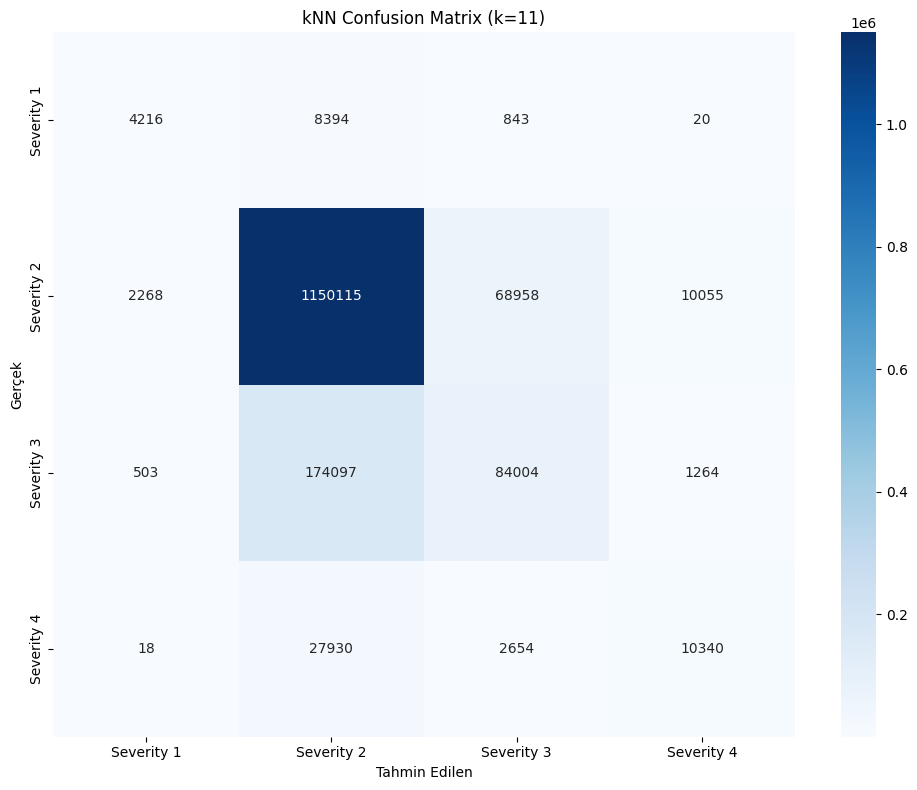

In [28]:
# Confusion Matrix Görselleştirme
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4'],
            yticklabels=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4'])
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title(f'kNN Confusion Matrix (k={BEST_K})')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Confusion matrix'i metriklere ekle
knn_metrics['confusion_matrix'] = cm.tolist()

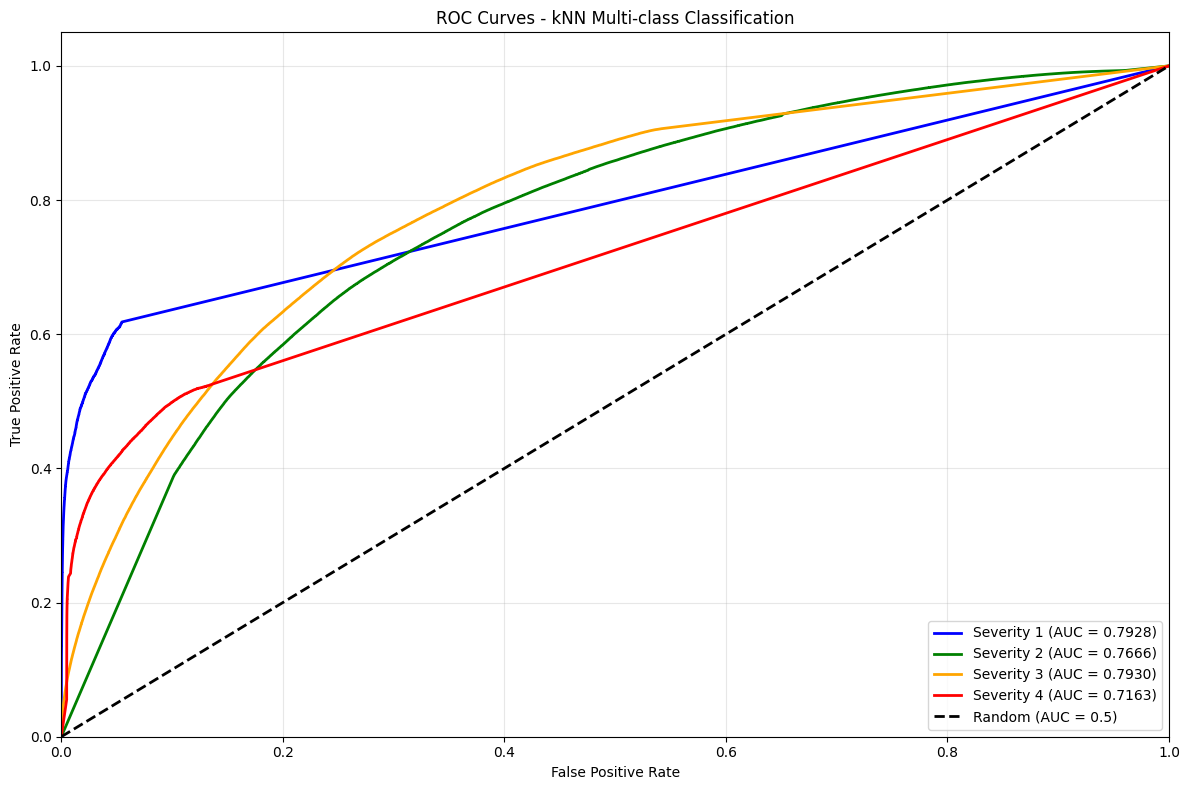


📊 Ortalama AUC-ROC: 0.7672


In [29]:
# ROC-AUC Hesaplama (One-vs-Rest)
# Çok sınıflı ROC için etiketleri binarize et
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Her sınıf için ROC eğrisi
plt.figure(figsize=(12, 8))

colors = ['blue', 'green', 'orange', 'red']
auc_scores = {}

for i, (class_val, color) in enumerate(zip(classes, colors)):
    if i < y_pred_proba.shape[1]:
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores[f'Severity_{int(class_val)}'] = float(roc_auc)
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'Severity {int(class_val)} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - kNN Multi-class Classification')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Ortalama AUC
mean_auc = np.mean(list(auc_scores.values()))
print(f"\n📊 Ortalama AUC-ROC: {mean_auc:.4f}")
knn_metrics['auc_roc_mean'] = float(mean_auc)
knn_metrics['auc_roc_per_class'] = auc_scores

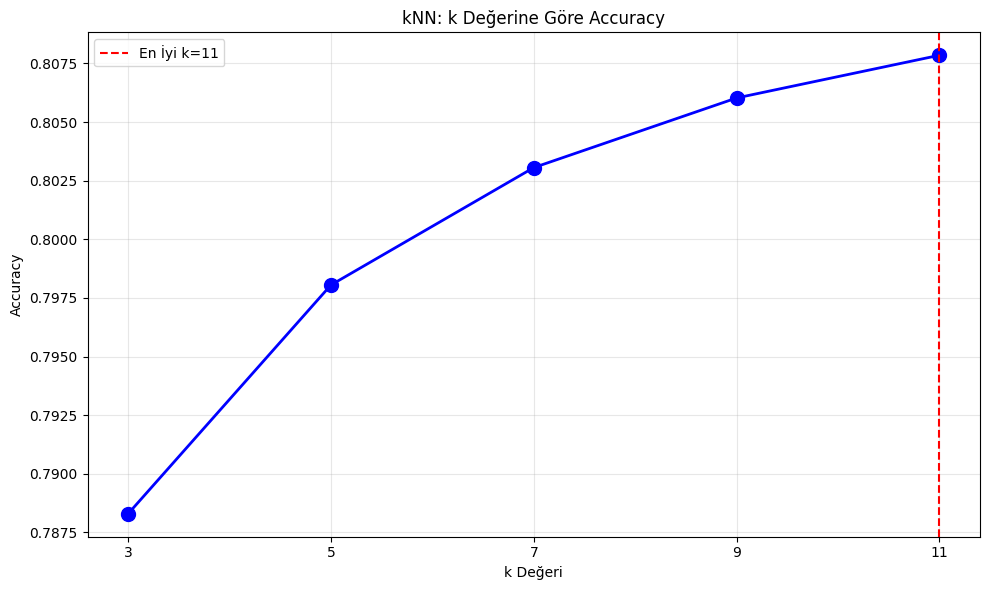

In [30]:
# k değerlerine göre accuracy grafiği
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['k'], results_df['accuracy'], 'bo-', linewidth=2, markersize=10)
plt.xlabel('k Değeri')
plt.ylabel('Accuracy')
plt.title('kNN: k Değerine Göre Accuracy')
plt.xticks(k_values)
plt.grid(True, alpha=0.3)

# En iyi k'yı işaretle
plt.axvline(x=BEST_K, color='red', linestyle='--', label=f'En İyi k={BEST_K}')
plt.legend()
plt.tight_layout()
plt.savefig('knn_k_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

## 🎨 Bölüm 6: K-Means Kümeleme + Görselleştirme

In [31]:
# K-Means için özellik seçimi
# Coğrafi ve çevresel faktörlere göre kazaları kümeleyeceğiz

kmeans_features = [
    'Start_Lat', 'Start_Lng', 'Temperature(F)', 'Humidity(%)',
    'Visibility(mi)', 'Wind_Speed(mph)'
]

# PySpark VectorAssembler ile özellik vektörü oluştur
assembler = VectorAssembler(inputCols=kmeans_features, outputCol="features", handleInvalid="skip")
df_kmeans = assembler.transform(df_sample)

# Ölçekleme
scaler_spark = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler_spark.fit(df_kmeans)
df_kmeans_scaled = scaler_model.transform(df_kmeans)

print("✅ K-Means için özellikler hazırlandı!")

✅ K-Means için özellikler hazırlandı!


In [32]:
# Elbow Method - Optimal k değerini bul
print("📊 Elbow Method ile Optimal k Belirleme...")
print("="*60)

# Daha küçük bir örnekle çalış (hız için)
df_kmeans_sample = df_kmeans_scaled.sample(fraction=0.1, seed=42)

k_range = range(2, 11)
costs = []

for k in k_range:
    print(f"🔄 k={k} test ediliyor...")

    kmeans = KMeans(k=k, seed=42, featuresCol="scaled_features", predictionCol="cluster")
    model = kmeans.fit(df_kmeans_sample)

    # WSSSE (Within Set Sum of Squared Errors)
    cost = model.summary.trainingCost
    costs.append(cost)

    print(f"   WSSSE: {cost:.2f}")

print("\n✅ Elbow analizi tamamlandı!")

📊 Elbow Method ile Optimal k Belirleme...
🔄 k=2 test ediliyor...
   WSSSE: 3761126.79
🔄 k=3 test ediliyor...
   WSSSE: 3270326.39
🔄 k=4 test ediliyor...
   WSSSE: 2783770.14
🔄 k=5 test ediliyor...
   WSSSE: 2560101.72
🔄 k=6 test ediliyor...
   WSSSE: 2297291.42
🔄 k=7 test ediliyor...
   WSSSE: 2187367.13
🔄 k=8 test ediliyor...
   WSSSE: 2063901.40
🔄 k=9 test ediliyor...
   WSSSE: 1913146.63
🔄 k=10 test ediliyor...
   WSSSE: 1854367.01

✅ Elbow analizi tamamlandı!


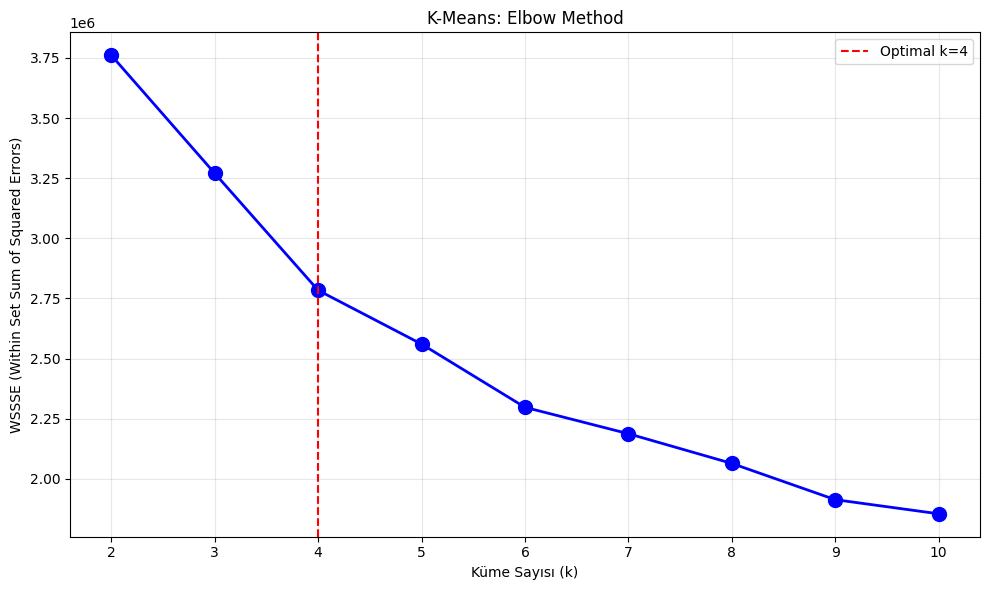

In [33]:
# Elbow grafiği
plt.figure(figsize=(10, 6))
plt.plot(list(k_range), costs, 'bo-', linewidth=2, markersize=10)
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('WSSSE (Within Set Sum of Squared Errors)')
plt.title('K-Means: Elbow Method')
plt.xticks(list(k_range))
plt.grid(True, alpha=0.3)

# Optimal k'yı işaretle (genellikle dirsek noktası)
optimal_k = 4  # Görsel incelemeye göre ayarlayın
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
plt.legend()
plt.tight_layout()
plt.savefig('elbow_method.png', dpi=150, bbox_inches='tight')
plt.show()

In [34]:
# Final K-Means Modeli
OPTIMAL_K = 4

print(f"🎯 Final K-Means Modeli (k={OPTIMAL_K})")
print("="*60)

kmeans_final = KMeans(k=OPTIMAL_K, seed=42, featuresCol="scaled_features", predictionCol="cluster")
kmeans_model = kmeans_final.fit(df_kmeans_scaled)

# Küme atamaları
df_clustered = kmeans_model.transform(df_kmeans_scaled)

# Küme merkezleri
centers = kmeans_model.clusterCenters()
print("\n📍 Küme Merkezleri:")
for i, center in enumerate(centers):
    print(f"   Küme {i}: {center[:3]}... (ilk 3 özellik)")

🎯 Final K-Means Modeli (k=4)

📍 Küme Merkezleri:
   Küme 0: [ 0.71691627  0.72876779 -0.52904337]... (ilk 3 özellik)
   Küme 1: [ 0.11598461 -1.33011964  0.14507557]... (ilk 3 özellik)
   Küme 2: [ 0.37790772  0.0623312  -0.76627203]... (ilk 3 özellik)
   Küme 3: [-1.02871536  0.50822112  0.71774898]... (ilk 3 özellik)



📊 Küme Dağılımı:
+-------+-------+
|cluster|  count|
+-------+-------+
|      0|2408308|
|      1|2217116|
|      2| 858719|
|      3|2244251|
+-------+-------+



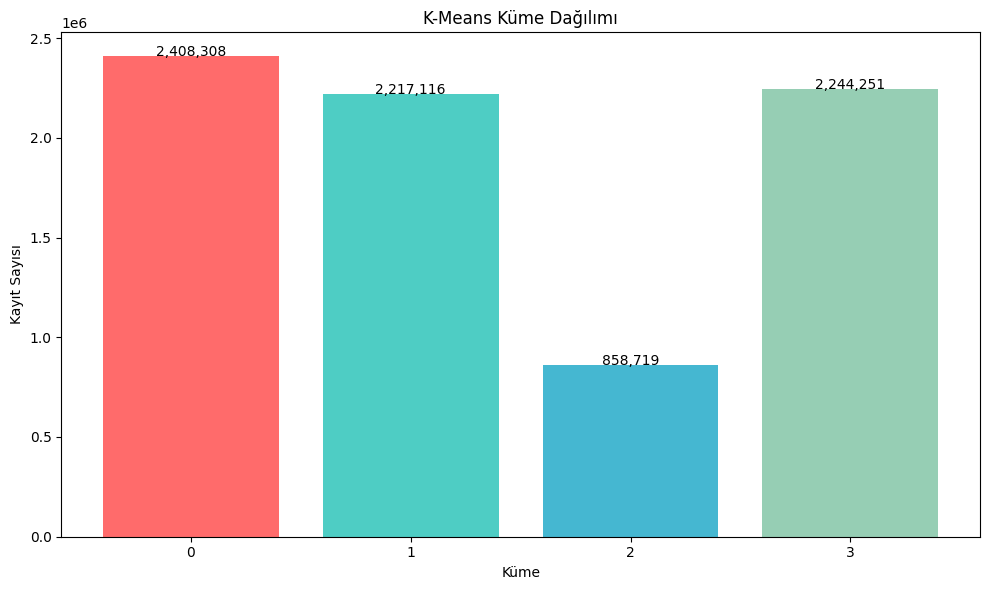

In [35]:
# Küme dağılımı
print("\n📊 Küme Dağılımı:")
cluster_dist = df_clustered.groupBy('cluster').count().orderBy('cluster')
cluster_dist.show()

cluster_pd = cluster_dist.toPandas()

plt.figure(figsize=(10, 6))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
plt.bar(cluster_pd['cluster'].astype(str), cluster_pd['count'], color=colors[:len(cluster_pd)])
plt.xlabel('Küme')
plt.ylabel('Kayıt Sayısı')
plt.title('K-Means Küme Dağılımı')
for i, v in enumerate(cluster_pd['count']):
    plt.text(i, v + 500, f'{v:,}', ha='center', fontsize=10)
plt.tight_layout()
plt.savefig('cluster_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

🗺️ Coğrafi Küme Görselleştirmesi (Amerika Haritası)...
📊 Görselleştirme için 154,626 nokta kullanılıyor
📊 Filtreleme sonrası: 154,626 nokta


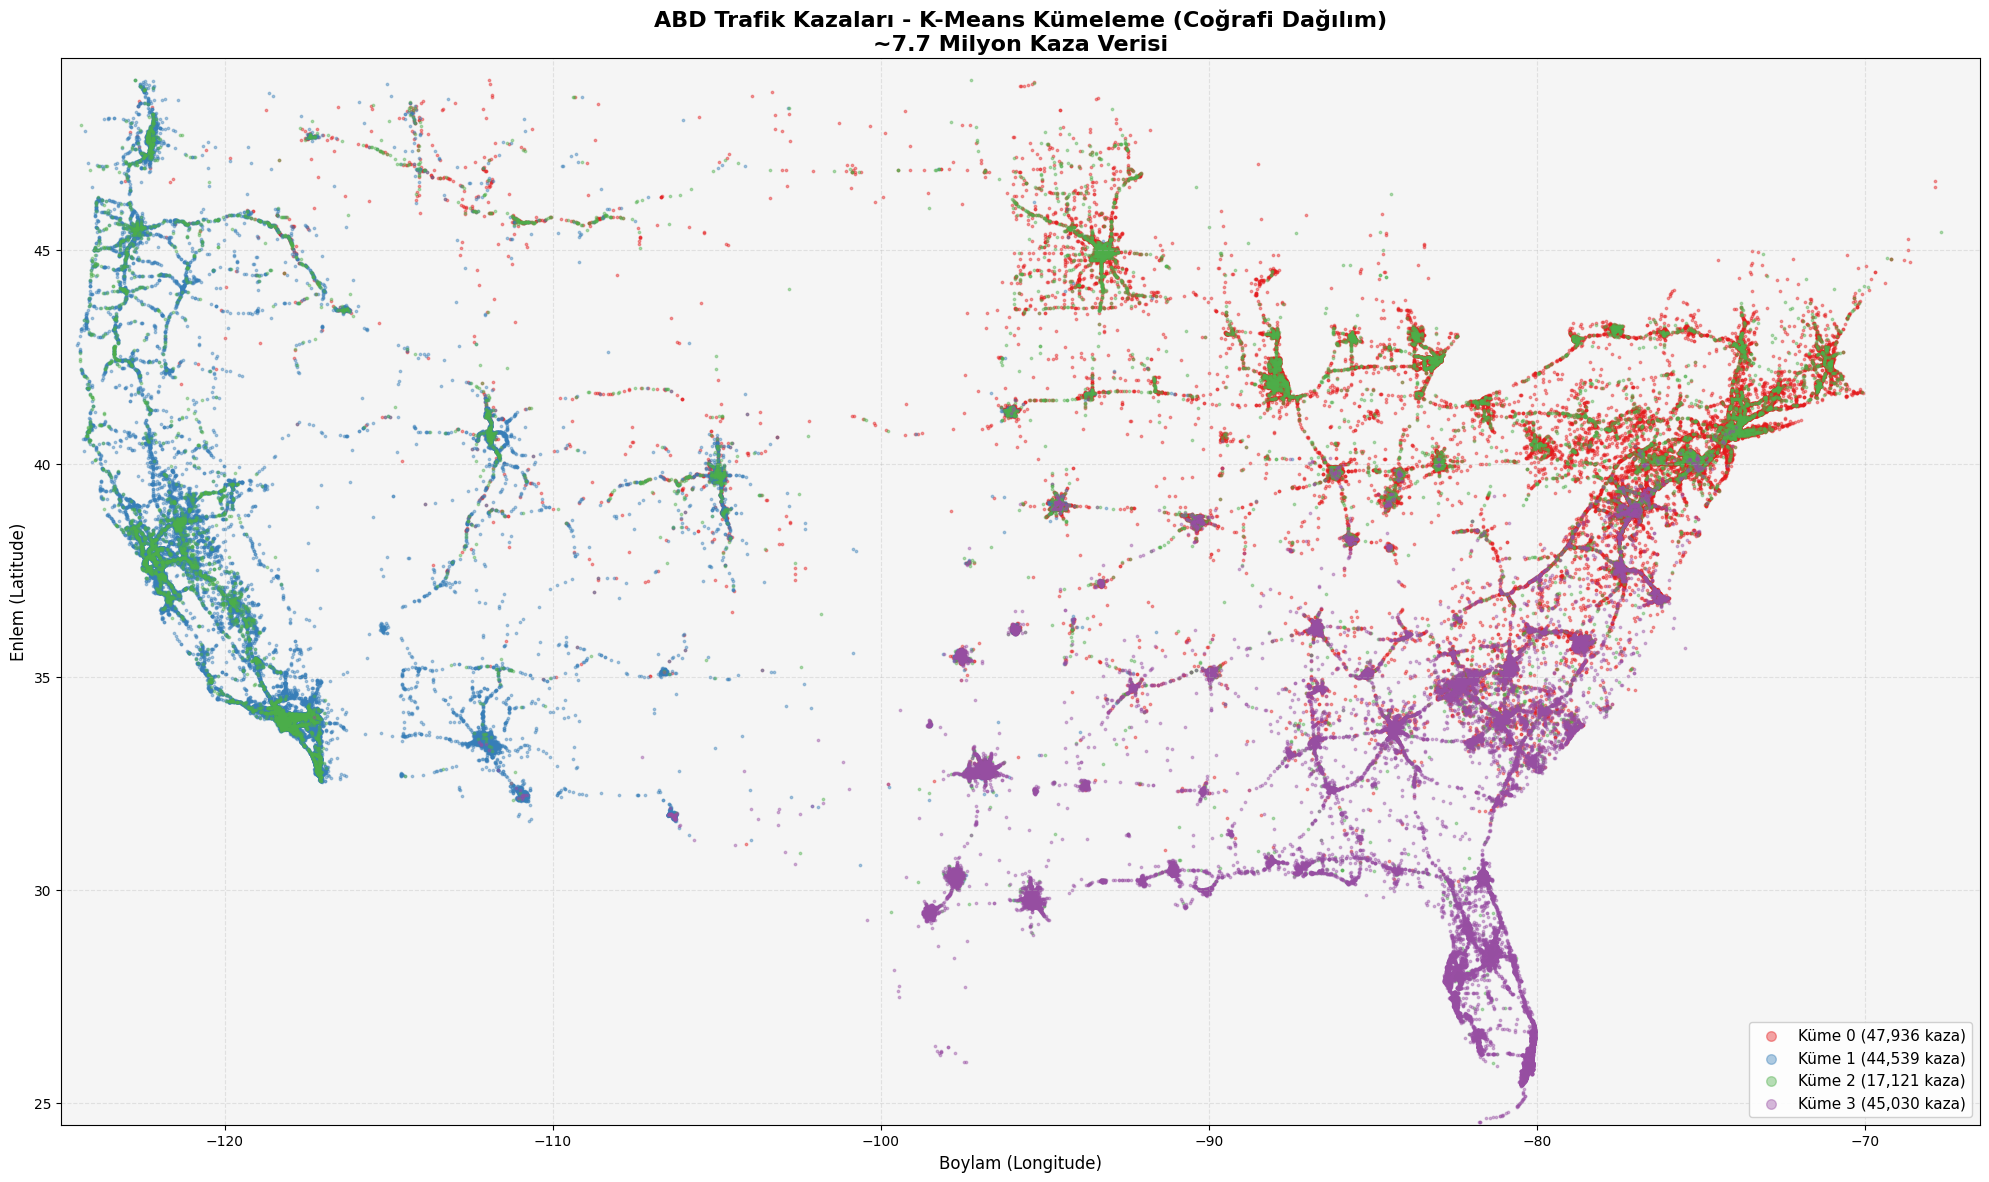

✅ Coğrafi görselleştirme tamamlandı!


In [36]:
# Kümelerin coğrafi görselleştirmesi - GELİŞTİRİLMİŞ VERSİYON
print("🗺️ Coğrafi Küme Görselleştirmesi (Amerika Haritası)...")

# Daha dengeli örnekleme için sample() kullan (limit yerine)
# Bu şekilde tüm bölgelerden orantılı veri alınır
df_viz = df_clustered.select('Start_Lat', 'Start_Lng', 'cluster', 'Severity').sample(fraction=0.02, seed=42).toPandas()

print(f"📊 Görselleştirme için {len(df_viz):,} nokta kullanılıyor")

# ABD ana kıtası sınırları (Alaska ve Hawaii hariç)
US_BOUNDS = {
    'lat_min': 24.5,   # Florida Keys
    'lat_max': 49.5,   # Kanada sınırı
    'lng_min': -125.0, # Batı kıyısı
    'lng_max': -66.5   # Doğu kıyısı
}

# Sadece ABD ana kıtasındaki verileri filtrele
df_viz_filtered = df_viz[
    (df_viz['Start_Lat'] >= US_BOUNDS['lat_min']) & 
    (df_viz['Start_Lat'] <= US_BOUNDS['lat_max']) &
    (df_viz['Start_Lng'] >= US_BOUNDS['lng_min']) & 
    (df_viz['Start_Lng'] <= US_BOUNDS['lng_max'])
]

print(f"📊 Filtreleme sonrası: {len(df_viz_filtered):,} nokta")

# Renk paleti - kümeler için belirgin renkler
cluster_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

fig, ax = plt.subplots(figsize=(20, 12))

# Her küme için ayrı scatter plot (legend için)
for cluster_id in sorted(df_viz_filtered['cluster'].unique()):
    cluster_data = df_viz_filtered[df_viz_filtered['cluster'] == cluster_id]
    ax.scatter(
        cluster_data['Start_Lng'], 
        cluster_data['Start_Lat'],
        c=cluster_colors[int(cluster_id) % len(cluster_colors)],
        label=f'Küme {int(cluster_id)} ({len(cluster_data):,} kaza)',
        alpha=0.4,
        s=3
    )

# ABD sınırlarına göre eksen limitleri
ax.set_xlim(US_BOUNDS['lng_min'], US_BOUNDS['lng_max'])
ax.set_ylim(US_BOUNDS['lat_min'], US_BOUNDS['lat_max'])

# Aspect ratio ayarı - harita orantılı görünsün (ABD için ~1.3)
ax.set_aspect(1.3)

# Başlık ve etiketler
ax.set_xlabel('Boylam (Longitude)', fontsize=12)
ax.set_ylabel('Enlem (Latitude)', fontsize=12)
ax.set_title('ABD Trafik Kazaları - K-Means Kümeleme (Coğrafi Dağılım)\n~7.7 Milyon Kaza Verisi', fontsize=16, fontweight='bold')

# Grid ekle
ax.grid(True, alpha=0.3, linestyle='--')

# Legend
ax.legend(loc='lower right', fontsize=11, markerscale=4, framealpha=0.9)

# Arka plan rengi
ax.set_facecolor('#f5f5f5')

plt.tight_layout()
plt.savefig('geographic_clusters.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Coğrafi görselleştirme tamamlandı!")

✅ geopandas yüklü

🗺️ ABD Haritası Arka Planlı Görselleştirme...
✅ 49 eyalet sınırı yüklendi


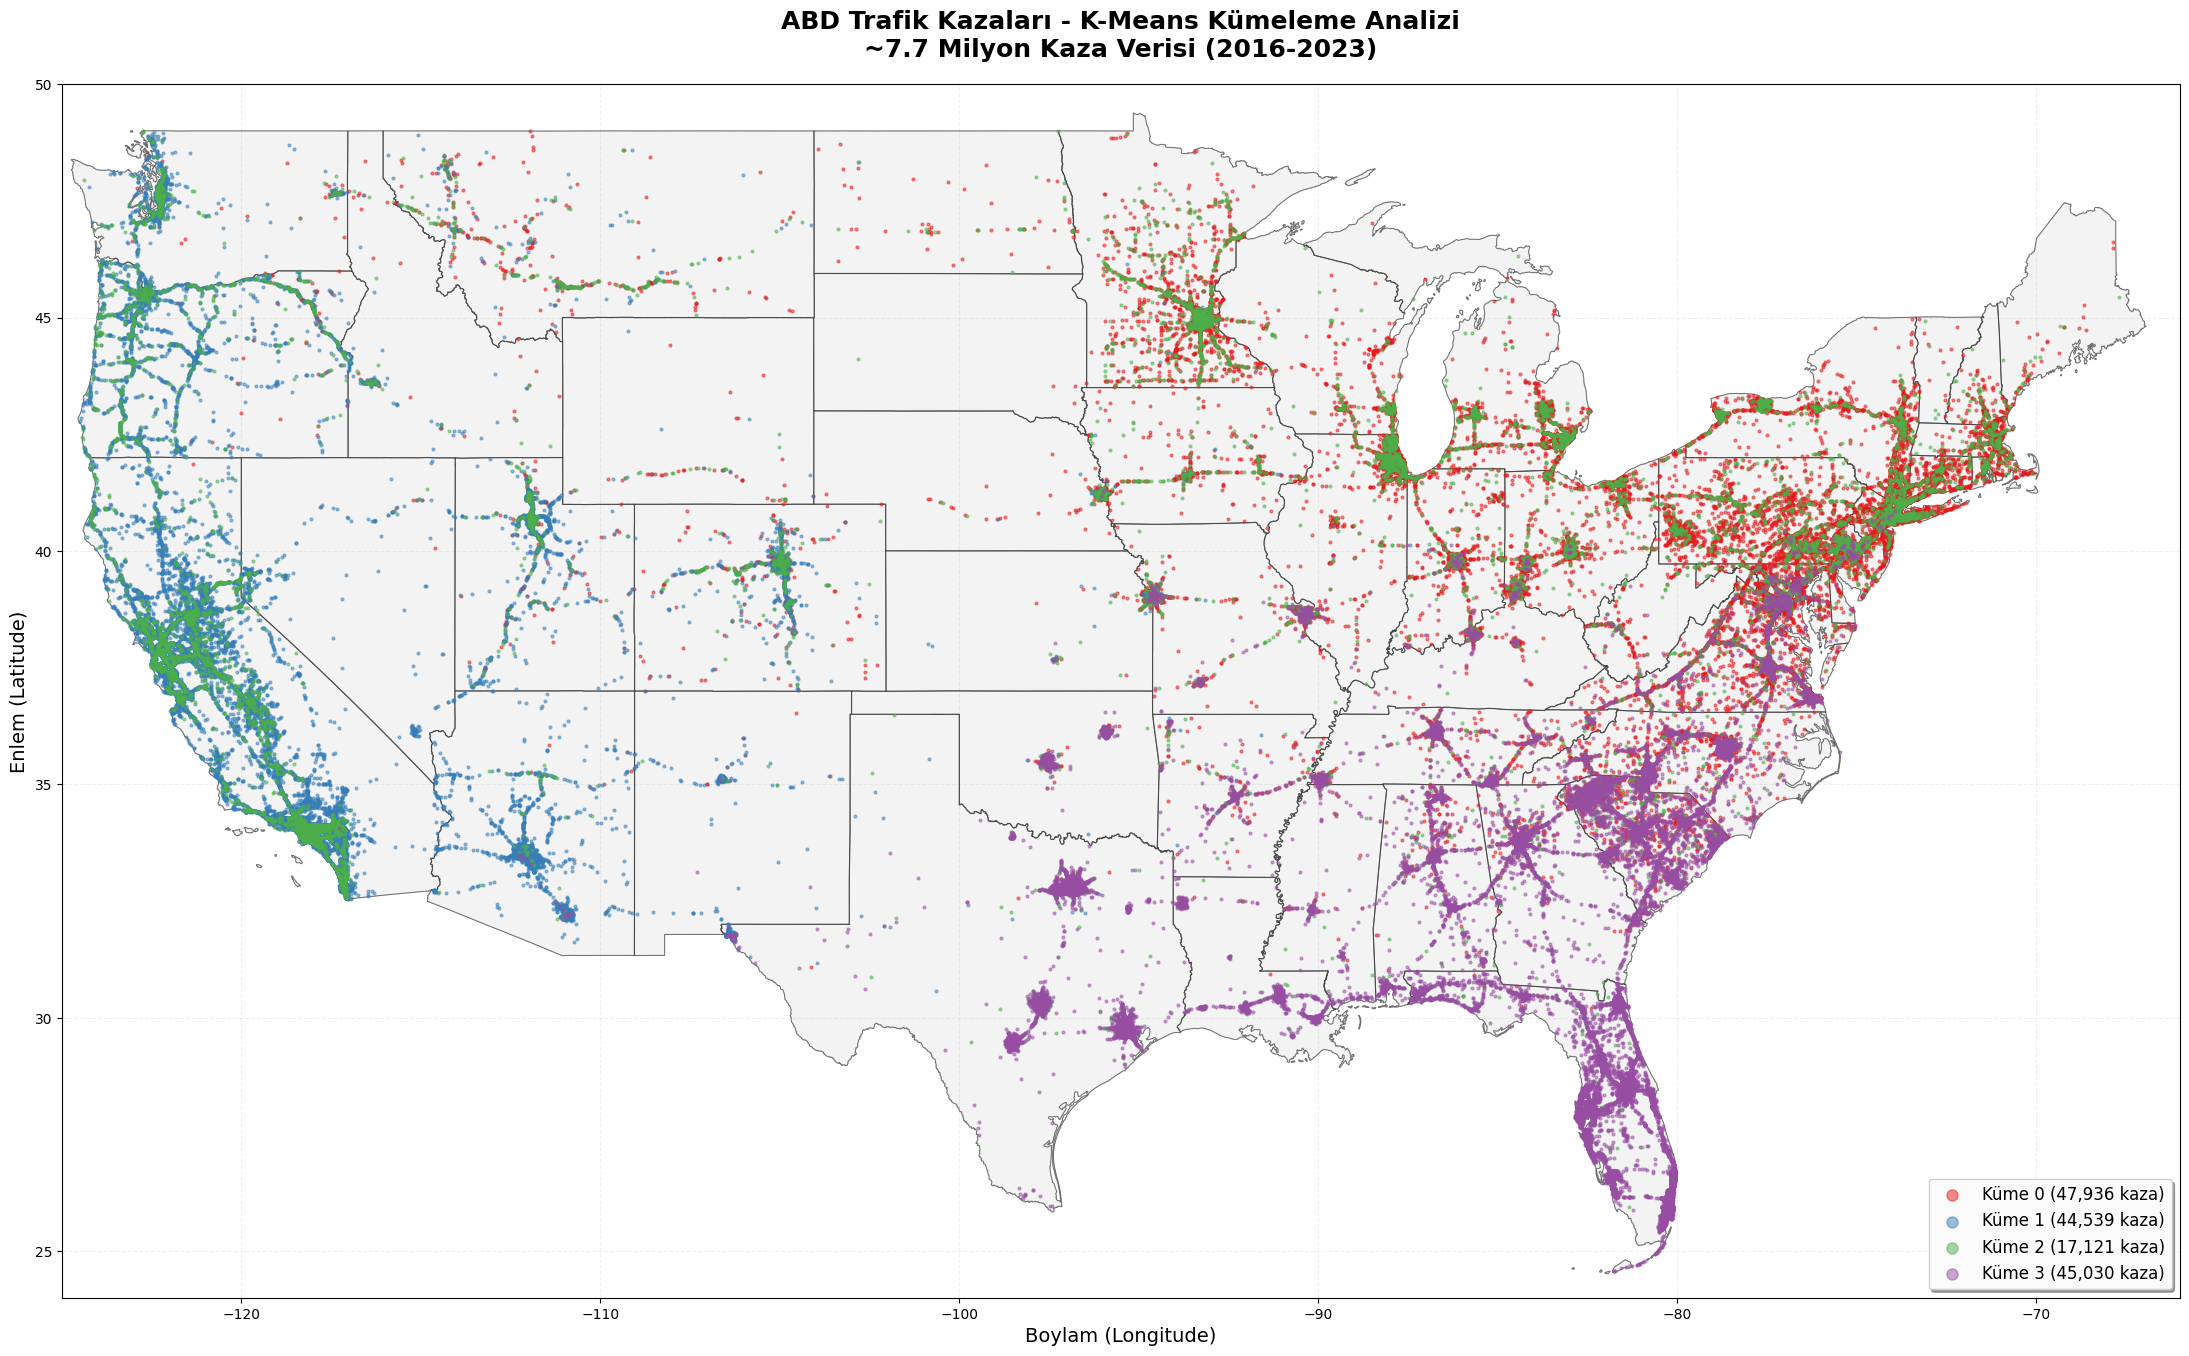


✅ ABD haritası arka planlı görselleştirme kaydedildi: geographic_clusters_map.png


In [37]:
# ============================================================================
# 🗺️ ABD HARİTASI ARKA PLANLI GELİŞMİŞ COĞRAFİ GÖRSELLEŞTİRME
# ============================================================================
# Bu hücre ABD eyalet sınırlarıyla birlikte harita oluşturur

try:
    import geopandas as gpd
    print("✅ geopandas yüklü")
except ImportError:
    print("📦 geopandas kuruluyor...")
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'geopandas', '-q'])
    import geopandas as gpd
    print("✅ geopandas kuruldu")

print("\n🗺️ ABD Haritası Arka Planlı Görselleştirme...")

# ABD eyalet sınırlarını indir (Natural Earth verisi)
try:
    # Census Bureau'dan ABD eyalet sınırları
    us_states_url = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_5m.zip'
    us_states = gpd.read_file(us_states_url)
    
    # Alaska, Hawaii ve ABD dışı bölgeleri çıkar
    excluded = ['AK', 'HI', 'PR', 'VI', 'GU', 'AS', 'MP']
    us_continental = us_states[~us_states['STUSPS'].isin(excluded)]
    
    print(f"✅ {len(us_continental)} eyalet sınırı yüklendi")
    
    # Görselleştirme
    fig, ax = plt.subplots(figsize=(22, 14))
    
    # Eyalet sınırlarını çiz
    us_continental.boundary.plot(ax=ax, linewidth=0.8, color='#333333', alpha=0.6)
    us_continental.plot(ax=ax, color='#e8e8e8', edgecolor='#666666', linewidth=0.3, alpha=0.5)
    
    # Her küme için scatter plot
    cluster_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
    
    for cluster_id in sorted(df_viz_filtered['cluster'].unique()):
        cluster_data = df_viz_filtered[df_viz_filtered['cluster'] == cluster_id]
        ax.scatter(
            cluster_data['Start_Lng'], 
            cluster_data['Start_Lat'],
            c=cluster_colors[int(cluster_id) % len(cluster_colors)],
            label=f'Küme {int(cluster_id)} ({len(cluster_data):,} kaza)',
            alpha=0.5,
            s=4,
            zorder=5
        )
    
    # Eksen ayarları
    ax.set_xlim(-125, -66)
    ax.set_ylim(24, 50)
    ax.set_aspect(1.3)
    
    # Başlık ve etiketler
    ax.set_xlabel('Boylam (Longitude)', fontsize=14)
    ax.set_ylabel('Enlem (Latitude)', fontsize=14)
    ax.set_title('ABD Trafik Kazaları - K-Means Kümeleme Analizi\n~7.7 Milyon Kaza Verisi (2016-2023)', 
                 fontsize=18, fontweight='bold', pad=20)
    
    # Legend
    legend = ax.legend(loc='lower right', fontsize=12, markerscale=4, 
                       framealpha=0.95, fancybox=True, shadow=True)
    
    # Grid
    ax.grid(True, alpha=0.2, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('geographic_clusters_map.png', dpi=250, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("\n✅ ABD haritası arka planlı görselleştirme kaydedildi: geographic_clusters_map.png")
    
except Exception as e:
    print(f"⚠️ ABD haritası yüklenemedi: {e}")
    print("   Önceki basit görselleştirme kullanılacak.")

In [38]:
# Küme karakteristikleri analizi
print("📊 Küme Karakteristikleri:")
print("="*60)

cluster_stats = df_clustered.groupBy('cluster').agg(
    mean('Temperature(F)').alias('Avg_Temp'),
    mean('Humidity(%)').alias('Avg_Humidity'),
    mean('Visibility(mi)').alias('Avg_Visibility'),
    mean('Wind_Speed(mph)').alias('Avg_Wind'),
    mean('Severity').alias('Avg_Severity'),
    count('*').alias('Count')
).orderBy('cluster')

cluster_stats.show()

📊 Küme Karakteristikleri:
+-------+-----------------+-----------------+-----------------+-----------------+------------------+-------+
|cluster|         Avg_Temp|     Avg_Humidity|   Avg_Visibility|         Avg_Wind|      Avg_Severity|  Count|
+-------+-----------------+-----------------+-----------------+-----------------+------------------+-------+
|      0|51.70683897012517|64.70590897724603|9.888078095403072|8.143666375051659| 2.265800719841482|2408308|
|      1|64.39311676474998|53.27682790784482|9.826750439485227|6.921988488942909| 2.175358889656653|2217116|
|      2|47.25048946584244|91.10693020116717|3.141901633753017|7.521066640288874|2.2315087939127936| 858719|
|      3|75.16551027075934|66.32587623615088|9.782959642203275|8.011002576315443|2.1843238568235015|2244251|
+-------+-----------------+-----------------+-----------------+-----------------+------------------+-------+



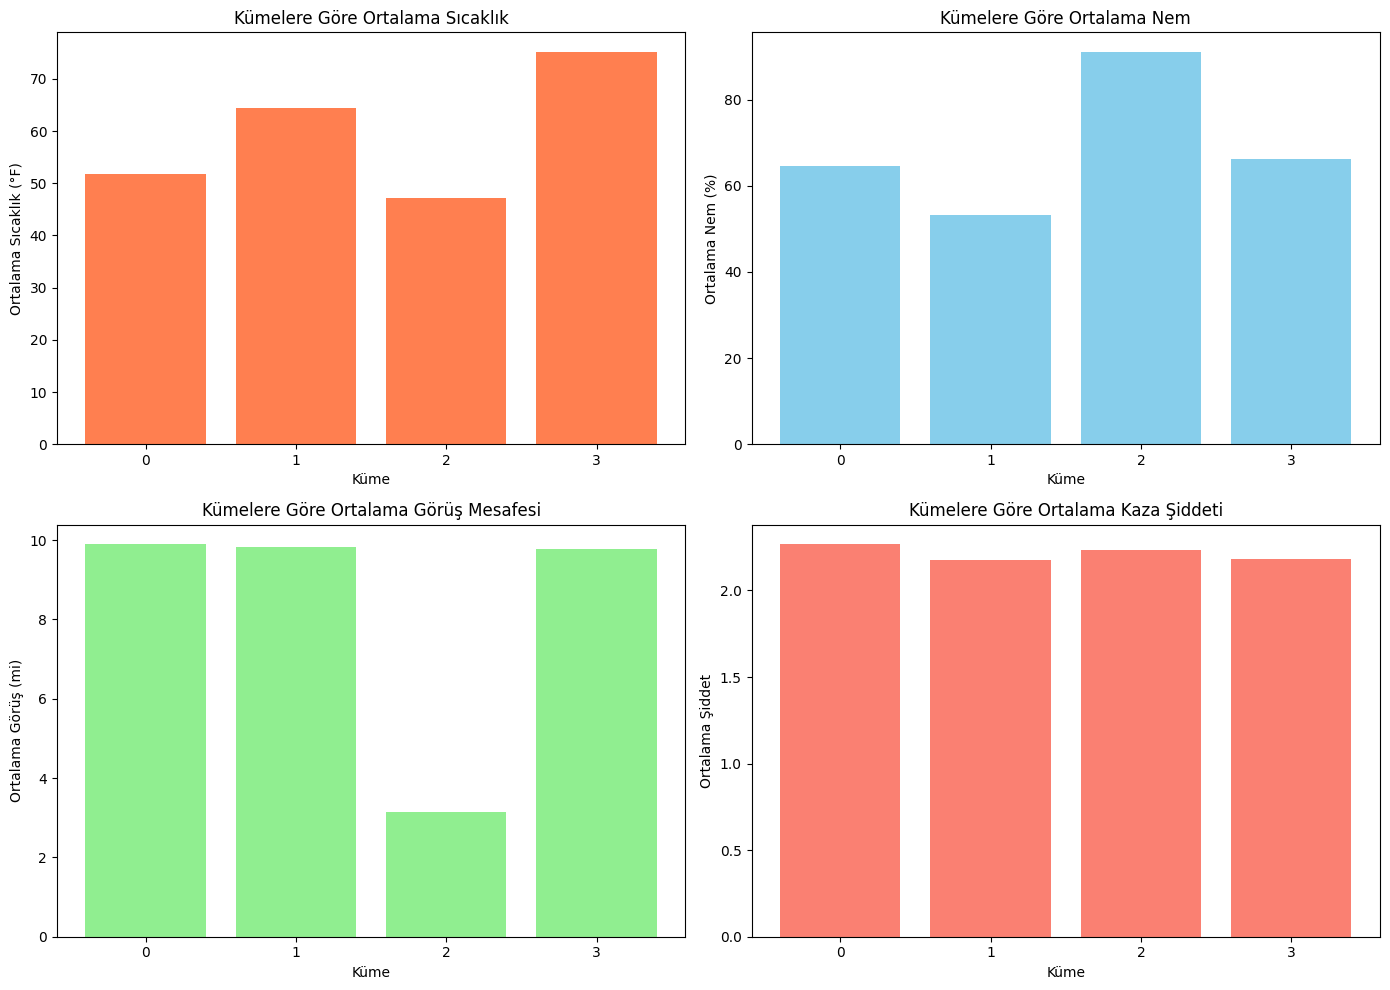

In [39]:
# Küme karakteristikleri görselleştirmesi
cluster_stats_pd = cluster_stats.toPandas()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Ortalama Sıcaklık
axes[0, 0].bar(cluster_stats_pd['cluster'].astype(str), cluster_stats_pd['Avg_Temp'], color='coral')
axes[0, 0].set_xlabel('Küme')
axes[0, 0].set_ylabel('Ortalama Sıcaklık (°F)')
axes[0, 0].set_title('Kümelere Göre Ortalama Sıcaklık')

# Ortalama Nem
axes[0, 1].bar(cluster_stats_pd['cluster'].astype(str), cluster_stats_pd['Avg_Humidity'], color='skyblue')
axes[0, 1].set_xlabel('Küme')
axes[0, 1].set_ylabel('Ortalama Nem (%)')
axes[0, 1].set_title('Kümelere Göre Ortalama Nem')

# Ortalama Görüş Mesafesi
axes[1, 0].bar(cluster_stats_pd['cluster'].astype(str), cluster_stats_pd['Avg_Visibility'], color='lightgreen')
axes[1, 0].set_xlabel('Küme')
axes[1, 0].set_ylabel('Ortalama Görüş (mi)')
axes[1, 0].set_title('Kümelere Göre Ortalama Görüş Mesafesi')

# Ortalama Kaza Şiddeti
axes[1, 1].bar(cluster_stats_pd['cluster'].astype(str), cluster_stats_pd['Avg_Severity'], color='salmon')
axes[1, 1].set_xlabel('Küme')
axes[1, 1].set_ylabel('Ortalama Şiddet')
axes[1, 1].set_title('Kümelere Göre Ortalama Kaza Şiddeti')

plt.tight_layout()
plt.savefig('cluster_characteristics.png', dpi=150, bbox_inches='tight')
plt.show()

In [40]:
# Silhouette Score hesaplama (sklearn ile)
# Küçük bir örnekle silhouette hesapla
df_sil = df_clustered.select(kmeans_features + ['cluster']).limit(20000).toPandas()
df_sil = df_sil.dropna()

X_sil = df_sil[kmeans_features].values
y_sil = df_sil['cluster'].values

sil_score = silhouette_score(X_sil, y_sil)
print(f"📊 Silhouette Score: {sil_score:.4f}")

# K-Means metriklerini kaydet
kmeans_metrics = {
    'model': 'K-Means',
    'k_value': int(OPTIMAL_K),
    'wssse': float(kmeans_model.summary.trainingCost),
    'silhouette_score': float(sil_score),
    'cluster_sizes': cluster_pd.to_dict('records'),
    'cluster_centers': [center.tolist() for center in centers],
    'cluster_stats': cluster_stats_pd.to_dict('records')
}

📊 Silhouette Score: 0.1602


## 💾 Bölüm 7: Çıktıları JSON Olarak Dışa Aktarma

Tüm sonuçları JSON dosyaları olarak kaydedip bilgisayarınıza indireceğiz.
Bu dosyaları daha sonra lokal MongoDB'ye yükleyeceksiniz.

In [41]:
# Çıktı klasörü oluştur
import os
OUTPUT_DIR = 'mongodb_export'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"📁 Çıktı klasörü oluşturuldu: {OUTPUT_DIR}")

📁 Çıktı klasörü oluşturuldu: mongodb_export


In [42]:
# 1. kNN Sonuçlarını kaydet
knn_metrics['timestamp'] = datetime.now().isoformat()

with open(f'{OUTPUT_DIR}/knn_results.json', 'w', encoding='utf-8') as f:
    json.dump(knn_metrics, f, indent=2, ensure_ascii=False)

print("✅ kNN sonuçları kaydedildi: knn_results.json")

✅ kNN sonuçları kaydedildi: knn_results.json


In [43]:
# 2. K-Means Sonuçlarını kaydet
kmeans_metrics['timestamp'] = datetime.now().isoformat()

with open(f'{OUTPUT_DIR}/kmeans_results.json', 'w', encoding='utf-8') as f:
    json.dump(kmeans_metrics, f, indent=2, ensure_ascii=False)

print("✅ K-Means sonuçları kaydedildi: kmeans_results.json")

✅ K-Means sonuçları kaydedildi: kmeans_results.json


In [44]:
# ============================================================================
# 3. HAM VERİ - JSON EXPORT (TÜM 7.7M VERİ)
# ============================================================================
# Lokal Runtime ile tüm veriyi JSON olarak kaydet

print("📊 Ham veri hazırlanıyor - TÜM 7.7M VERİ...")
print("="*60)

# Toplam kayıt sayısı
total_raw = df_spark.count()
print(f"📊 Toplam kayıt: {total_raw:,}")

# PySpark ile doğrudan JSON yaz (en hızlı yöntem)
print(f"\n⏳ JSON formatında yazılıyor...")
output_path = f'{OUTPUT_DIR}/us_accidents_raw_spark'
print(f"📁 Hedef: {output_path}")

df_spark.write.mode('overwrite').json(output_path)

# Dosya bilgisi
spark_json_files = glob.glob(f'{output_path}/part-*.json')
total_size = sum(os.path.getsize(f) for f in spark_json_files) / (1024**3)

print(f"\n✅ Ham veri kaydedildi!")
print(f"📊 Parça sayısı: {len(spark_json_files)}")
print(f"📊 Toplam boyut: {total_size:.2f} GB")
print(f"📁 Konum: {output_path}")

gc.collect()

📊 Ham veri hazırlanıyor - TÜM 7.7M VERİ...
📊 Toplam kayıt: 7,728,394

⏳ JSON formatında yazılıyor...
📁 Hedef: mongodb_export/us_accidents_raw_spark


Py4JJavaError: An error occurred while calling o1483.json.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:735)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:270)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:286)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:978)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:660)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:700)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:788)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:188)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:269)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:304)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:190)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:190)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:374)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:402)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:374)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:859)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:388)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:361)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:240)
	at org.apache.spark.sql.DataFrameWriter.json(DataFrameWriter.scala:774)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:547)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:568)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:591)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:688)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:79)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1907)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1867)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1840)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:242)
	at org.apache.spark.util.SparkFileUtils.createTempDir(SparkFileUtils.scala:103)
	at org.apache.spark.util.SparkFileUtils.createTempDir$(SparkFileUtils.scala:102)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:94)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:372)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:964)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:194)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:217)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:91)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1120)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1129)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:467)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:438)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:515)
	... 25 more


In [ ]:
# ============================================================================
# 4. TEMİZLENMİŞ VERİ - JSON EXPORT (TÜM 7.7M VERİ)
# ============================================================================

print("📊 Temizlenmiş veri hazırlanıyor - TÜM 7.7M VERİ...")
print("="*60)

# Toplam kayıt sayısı
total_cleaned = df_sample.count()
print(f"📊 Toplam kayıt: {total_cleaned:,}")

# PySpark ile doğrudan JSON yaz
print(f"\n⏳ JSON formatında yazılıyor...")
output_path = f'{OUTPUT_DIR}/us_accidents_cleaned_spark'
print(f"📁 Hedef: {output_path}")

df_sample.write.mode('overwrite').json(output_path)

# Dosya bilgisi
spark_cleaned_files = glob.glob(f'{output_path}/part-*.json')
total_size = sum(os.path.getsize(f) for f in spark_cleaned_files) / (1024**3)

print(f"\n✅ Temizlenmiş veri kaydedildi!")
print(f"📊 Parça sayısı: {len(spark_cleaned_files)}")
print(f"📊 Toplam boyut: {total_size:.2f} GB")
print(f"📁 Konum: {output_path}")

gc.collect()

In [ ]:
# ============================================================================
# 5. KÜMELENMİŞ VERİ - JSON EXPORT (TÜM 7.7M VERİ)
# ============================================================================

print("📊 Kümelenmiş veri hazırlanıyor - TÜM 7.7M VERİ...")
print("="*60)

# Kümelenmiş veriyi seç
df_clustered_export = df_clustered.select(
    'Start_Lat', 'Start_Lng', 'Temperature(F)', 'Humidity(%)',
    'Visibility(mi)', 'Wind_Speed(mph)', 'Severity', 'cluster'
)

total_clustered = df_clustered_export.count()
print(f"📊 Toplam kayıt: {total_clustered:,}")

# PySpark ile doğrudan JSON yaz
print(f"\n⏳ JSON formatında yazılıyor...")
output_path = f'{OUTPUT_DIR}/us_accidents_clustered_spark'
print(f"📁 Hedef: {output_path}")

df_clustered_export.write.mode('overwrite').json(output_path)

# Dosya bilgisi
spark_clustered_files = glob.glob(f'{output_path}/part-*.json')
total_size = sum(os.path.getsize(f) for f in spark_clustered_files) / (1024**3)

print(f"\n✅ Kümelenmiş veri kaydedildi!")
print(f"📊 Parça sayısı: {len(spark_clustered_files)}")
print(f"📊 Toplam boyut: {total_size:.2f} GB")
print(f"📁 Konum: {output_path}")

gc.collect()

In [ ]:
# Tüm dosyaları listele
print("\n📁 Oluşturulan Dosyalar:")
print("="*60)

for f in os.listdir(OUTPUT_DIR):
    size_kb = os.path.getsize(f'{OUTPUT_DIR}/{f}') / 1024
    print(f"   📄 {f}: {size_kb:.2f} KB")

In [ ]:
# ============================================================================
# DOSYALARI DÜZENLE - LOKAL RUNTIME
# ============================================================================
# Lokal runtime'da ZIP gerekmez, dosyalar zaten lokal diskte

import shutil

print("📁 Çıktı Dosyaları Düzenleniyor...")
print("="*60)

# Görsel dosyalarını outputs klasörüne kopyala
image_files = ['severity_distribution.png', 'confusion_matrix.png', 'roc_curves.png',
               'knn_k_accuracy.png', 'elbow_method.png', 'cluster_distribution.png',
               'geographic_clusters.png', 'cluster_characteristics.png']

copied_count = 0
for img in image_files:
    # Mevcut dizinde veya outputs dizininde ara
    if os.path.exists(img):
        shutil.copy(img, OUTPUT_DIR)
        copied_count += 1
        print(f"   ✅ {img}")

print(f"\n📊 {copied_count} görsel dosya kopyalandı")
print(f"📁 Çıktı klasörü: {OUTPUT_DIR}")

# Klasör içeriğini listele
print(f"\n📁 Çıktı Klasörü İçeriği:")
print("-"*40)
for item in os.listdir(OUTPUT_DIR):
    item_path = os.path.join(OUTPUT_DIR, item)
    if os.path.isdir(item_path):
        # Klasör ise içindeki dosya sayısını göster
        file_count = len([f for f in os.listdir(item_path) if f.endswith('.json')])
        print(f"   📂 {item}/ ({file_count} JSON dosya)")
    else:
        size = os.path.getsize(item_path) / 1024
        print(f"   📄 {item} ({size:.1f} KB)")

In [ ]:
# ============================================================================
# LOKAL RUNTIME - İNDİRME GEREKMİYOR
# ============================================================================
# Dosyalar zaten lokal diskte kaydedildi

print("="*60)
print("✅ TÜM DOSYALAR LOKAL DİSKE KAYDEDİLDİ!")
print("="*60)

print(f"\n📁 Çıktı Klasörü: {OUTPUT_DIR}")
print("\n📋 Kaydedilen Dosyalar:")
print("   • knn_results.json - kNN model sonuçları")
print("   • kmeans_results.json - K-Means kümeleme sonuçları")
print("   • us_accidents_raw_spark/ - Ham veri (7.7M kayıt)")
print("   • us_accidents_cleaned_spark/ - Temizlenmiş veri (7.7M kayıt)")
print("   • us_accidents_clustered_spark/ - Kümelenmiş veri (7.7M kayıt)")
print("   • Görselleştirme PNG dosyaları")

print("\n📋 Sonraki Adımlar:")
print("   1. MongoDB'yi başlatın")
print("   2. 'mongodb_local_import.py' scriptini çalıştırın")
print("   3. Veya mongoimport ile JSON dosyalarını import edin")

## 📊 Bölüm 8: Özet ve Sonuçlar

In [ ]:
# ============================================================================
# PROJE ÖZETİ - TÜM 7.7M VERİ İŞLENDİ (LOKAL RUNTIME)
# ============================================================================
print("="*70)
print("        📊 PROJE ÖZETİ - LOKAL RUNTIME (32GB RAM)        ")
print("="*70)

# Toplam kayıt sayısını al
total_records = df_spark.count()
knn_records = len(df_pd) if 'df_pd' in dir() else 0

print("\n🖥️ ÇALIŞMA ORTAMI:")
print(f"   • Mod: Google Colab + Lokal Runtime")
print(f"   • RAM: {psutil.virtual_memory().total / (1024**3):.0f} GB")
print(f"   • CPU: {psutil.cpu_count()} çekirdek")

print("\n📁 VERİ SETİ:")
print(f"   • Kaynak: US Accidents Dataset (Kaggle)")
print(f"   • Toplam Kayıt: {total_records:,} (TÜM VERİ)")
print(f"   • kNN için Kullanılan: {knn_records:,} kayıt (TÜM VERİ)")
print(f"   • K-Means için Kullanılan: {total_records:,} kayıt (TÜM VERİ)")
print(f"   • JSON Export: {total_records:,} kayıt (TÜM VERİ)")
print(f"   • Özellik Sayısı: {len(feature_columns)}")

print("\n🎯 kNN SINIFLANDIRMA SONUÇLARI:")
print(f"   • En İyi k Değeri: {BEST_K}")
print(f"   • Accuracy: {accuracy:.4f}")
print(f"   • Precision (Weighted): {precision_weighted:.4f}")
print(f"   • Recall (Weighted): {recall_weighted:.4f}")
print(f"   • F1-Score (Weighted): {f1_weighted:.4f}")
print(f"   • AUC-ROC (Ortalama): {mean_auc:.4f}")

print("\n🎨 K-MEANS KÜMELEME SONUÇLARI:")
print(f"   • Optimal Küme Sayısı: {OPTIMAL_K}")
print(f"   • WSSSE: {kmeans_model.summary.trainingCost:.2f}")
print(f"   • Silhouette Score: {sil_score:.4f}")

print("\n💾 DIŞA AKTARILAN DOSYALAR:")
print(f"   📁 Konum: {OUTPUT_DIR}")
print(f"   • knn_results.json")
print(f"   • kmeans_results.json")
print(f"   • us_accidents_raw_spark/ ({total_records:,} kayıt)")
print(f"   • us_accidents_cleaned_spark/ ({total_records:,} kayıt)")
print(f"   • us_accidents_clustered_spark/ ({total_records:,} kayıt)")
print(f"   • Görselleştirme PNG dosyaları")

print("\n" + "="*70)
print("   ✅ TÜM 7.7M VERİ BAŞARIYLA İŞLENDİ VE KAYDEDİLDİ!   ")
print("="*70)

In [ ]:
# Spark oturumunu kapat
spark.stop()
print("\n✅ Spark oturumu kapatıldı.")